In [1]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandapower as pp

In [2]:
path_data_saved = os.path.abspath('generation/output/case118_l2rpn/2012/agent_results/Scenario_0')

In [3]:
from grid2op.EpisodeData import EpisodeData
from tqdm.notebook import tqdm

data_this_episode = EpisodeData.from_disk(path_data_saved, 'Scenario_0')

### Load partial results of failed agent

In [4]:
# Results of running with grid2op
# flows_a = np.array([obs.a_or for obs in data_this_episode.observations])
loads_p_runner = pd.DataFrame([obs.load_p for obs in data_this_episode.observations])
prods_p_runner = pd.DataFrame([obs.prod_p for obs in data_this_episode.observations])

In [5]:
total_played = data_this_episode.meta['nb_timestep_played']
total_tsteps = data_this_episode.meta['chronics_max_timestep']

print (f'Agent played only {total_played} / {total_tsteps} time steps')

Agent played only 255 / 8062 time steps


In [6]:
# Assuming here ... it keeps same sort of order
prods_p_runner.columns = data_this_episode.prod_names
loads_p_runner.columns = data_this_episode.load_names

print (f'Total prods runner lenght {prods_p_runner.shape[0]} - loads runner {loads_p_runner.shape[0]}')

Total prods runner lenght 256 - loads runner 256


In [7]:
prods_p_runner.tail(3)

,gen_3_0,gen_5_1,gen_7_2,gen_9_3,gen_11_4,gen_14_5,gen_17_6,gen_18_7,gen_23_8,gen_25_9,...,gen_58_54,gen_53_55,gen_14_56,gen_48_57,gen_55_58,gen_79_59,gen_89_60,gen_61_61,gen_10_62,gen_59_63
253,8.44,3.709539,343.549539,-268.849652,187.705796,-57.251643,188.348659,65.359539,4.099539,343.959539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,8.44,3.699539,343.939539,5.260348,183.845796,-57.191643,185.048659,-0.000461,4.099539,343.619539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
255,8.44,3.699539,343.939539,5.260348,183.845796,-57.191643,185.048659,-0.000461,4.099539,343.619539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Load full dispatch and loads

In [8]:
loads_p_generator = pd.read_csv('generation/output/case118_l2rpn/2012/Scenario_0/load_p.csv.bz2', sep=';')
prods_p_generator = pd.read_csv('generation/output/case118_l2rpn/2012/Scenario_0/prod_p.csv.bz2', sep=';')

print (f'Total prods with generator lenght {prods_p_generator.shape[0]} - loads runner {loads_p_generator.shape[0]}')

Total prods with generator lenght 8063 - loads runner 8063


In [9]:
prods_p_generator.tail(2)

,gen_3_0,gen_5_1,gen_7_2,gen_9_3,gen_11_4,gen_14_5,gen_17_6,gen_18_7,gen_23_8,gen_25_9,...,gen_58_54,gen_53_55,gen_14_56,gen_48_57,gen_55_58,gen_79_59,gen_89_60,gen_61_61,gen_10_62,gen_59_63
8061,1.25,3.7,343.66,0.00,146.80,59.46,146.95,0.0,4.1,343.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8062,1.31,3.7,343.71,274.14,144.02,59.47,144.62,65.4,4.1,344.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Check if loads are the same

Here we will check if rows are similar between loads_p_{runner and generators}. Just to make sure we are loading same information

In [10]:
last_idx_played = loads_p_runner.index[-1]

# Compare by rows two loads_p
loads_p_runner.eq(loads_p_generator.loc[:last_idx_played-1], axis=0).all(axis=1)

0       True
1       True
2       True
3       True
4       True
       ...  
251     True
252     True
253     True
254     True
255    False
Length: 256, dtype: bool

There is a inconsistent in the last row

### Load grids

We will load two different grids to fill information generated by the runner and the generator (implememented by Artelyst).

In [11]:
# data_this_episode.meta['grid_path']

In [12]:
grid_path = os.path.abspath('generation/input/case118_l2rpn/L2RPN_2020_case118_redesigned.json')

In [13]:
# Load the grid using pandapower
net = pp.from_json(grid_path)
net

This pandapower network includes the following parameter tables:
   - bus (118 elements)
   - load (99 elements)
   - gen (64 elements)
   - shunt (14 elements)
   - line (173 elements)
   - trafo (13 elements)
   - bus_geodata (118 elements)
 and the following results tables:
   - res_bus (118 elements)
   - res_line (173 elements)
   - res_trafo (13 elements)
   - res_load (99 elements)
   - res_shunt (14 elements)
   - res_gen (64 elements)

In [21]:
def check_loads_to_fill(load_r, load_g):
    print (f' - LOADS_P from -runner- and -dispatch- are equal ??? -> {load_r.eq(load_g).all()}')
    print (f' - Loads form runner have the same net_runner.load.name order ?? -> {np.all(load_r.index == net.load.name)} \n')

In [15]:
def check_prods_to_fill(prod_r, prod_g):
    
    slack = net.gen.loc[net.gen.slack==True, 'name'].tolist()[0]
    print (f'Slack gen name: {slack}')
    print (f'- Prods from runner have the same net_runner.gen.name order ?? -> {np.all(prod_r.index == net.gen.name)}\n')
    
    # Compare diference in slack bus
    print (f'-Slack theorical val (disptach) {prod_g[slack].round(1)} MW \
           \n-Slack computed val (power flow) {prod_r[slack].round(1)} MW')

### Select a time stet to analyze

In [16]:
last_valid_step = prods_p_generator.index[-1]

step = 10

In [17]:
gen_name_grid_order = net.gen.name
load_name_grid_order = net.load.name

In [18]:
# Extract MW Gen - Load same order as the net_runner to fill the grid
if step < last_idx_played:
    gen_pw_runner = prods_p_runner.loc[step, gen_name_grid_order]
    load_mw_runner = loads_p_runner.loc[step, load_name_grid_order]

# Extract MW Gen - Load same order as the net_gener to fill the grid
if step < prods_p_generator.shape[0]:
    gen_pw_gener = prods_p_generator.loc[step, gen_name_grid_order]
    load_mw_gener = loads_p_generator.loc[step, load_name_grid_order]

#### Check values before fill in grids

In [19]:
# Check if prods are equal
check_prods_to_fill(gen_pw_runner, gen_pw_gener)

Slack gen name: gen_68_28
- Prods from runner have the same net_runner.gen.name order ?? -> True

-Slack theorical val (disptach) 179.4 MW            
-Slack computed val (power flow) 377.6 MW


In [22]:
# Check if loads are equal
check_loads_to_fill(load_mw_runner, load_mw_gener)

 - LOADS_P from -runner- and -dispatch- are equal ??? -> True
 - Loads form runner have the same net_runner.load.name order ?? -> True 



#### Analysis for runner data

In [23]:
# For the runner data
net.gen.p_mw = gen_pw_runner.values
net.load.p_mw = load_mw_runner.values

In [25]:
# Run power flow
pp.runpp(net)

In [26]:
looses = net.res_line[['pl_mw', 'ql_mvar']]
looses.index = net.line.name
looses

,pl_mw,ql_mvar
name,,
0_1_0,0.112592,-2.218325
0_2_1,0.166447,-0.549616
10_11_2,0.000289,-0.536803
69_70_3,0.700485,1.879525
23_71_4,3.258961,7.861693
...,...,...
65_66_168,2.542919,8.672143
46_68_169,6.029969,12.283934
48_68_170,8.268717,18.328879


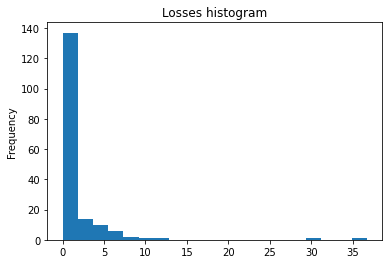

In [27]:
looses.pl_mw.plot.hist(bins=20, title='Losses histogram')

In [28]:
looses.agg(['min', 'max', 'mean', 'median']).T

,min,max,mean,median
pl_mw,-5.195844e-14,36.690263,1.529101,0.197208
ql_mvar,-1.330878e+02,108.806785,-0.923414,-1.403237


In [29]:
loss_in_percen = 100 * looses.pl_mw.sum() / net.gen.p_mw.sum()
loss_in_percen = round(loss_in_percen, 2)

print (f'Losses in % {loss_in_percen}')

Losses in % 8.76


In [30]:
# Larger lines with losses
criteria = 5 # MW

larger_line_losses = looses.loc[looses.pl_mw > criteria, ['pl_mw']]
larger_line_losses

,pl_mw
name,
68_74_9,7.191049
68_76_12,36.690263
74_76_14,5.133170
76_81_20,30.360644
79_95_41,8.230669
93_95_43,5.571486
79_97_45,6.785038
79_98_47,11.970386
97_99_52,9.283997


In [ ]:
from_bus = net_runner.line.set_index('name').loc[larger_line_losses.index, 'from_bus'].values
to_bus = net_runner.line.set_index('name').loc[larger_line_losses.index, 'to_bus'].values

#### Analysis for full dipatch data

In [ ]:
# # For full dispatch data
# net_gener.gen.p_mw = gen_pw_gener.values
net_gener.load.p_mw = load_mw_gener.values

In [ ]:
# # Run Power flow
# pp.runpp(net_gener)

In [ ]:
# looses = net_runner.res_line[['pl_mw', 'ql_mvar']]
# looses.index = net_runner.line.name
# looses

In [ ]:
# loss_in_percen = 100 * looses.pl_mw.sum() / net_runner.gen.p_mw.sum()
# loss_in_percen = round(loss_in_percen, 2)

# print (f'Losses in % {loss_in_percen}')